In [19]:
# !pip show pandas numpy matplotlib tensorflow optuna albumentations
!pip install --quiet tensorflow==2.4.1 matplotlib==3.2.2 pandas==1.1.5 numpy==1.19.5 albumentations==0.1.12

In [20]:
# Seems to be pretty decent dataset (train/valid/test split, good-quality images, lightweight) for this task.

# https://github.com/alexeygrigorev/clothing-dataset-small
!git clone https://github.com/alexeygrigorev/clothing-dataset-small

fatal: destination path 'clothing-dataset-small' already exists and is not an empty directory.


In [21]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [22]:
class Config:
    seed = 2020
    batch_size = 64
    img_width = 224
    img_height = 224
    num_classes = 10
    num_epochs = 300
    init_lr = 1e-2
    dataset_directory = "./clothing-dataset-small/"
    checkpt_directory = "/content/mobilenet_fashion_clothes_clf/"
    checkpt_tar_path = "/content/mobilenet_fashion_clothes_clf.tar.gz"

config = Config()

In [23]:
# Converts image pixel values to [0, 255] range.
# This seems to be necessary for this dataset as
# MobileNetV2 doesn't handle [-1, 1] range properly.
def preprocess_func(img):
    img = cv2.normalize(
        img, None, alpha=0, beta=255,
        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img = preprocess_input(img)
    return img

# Augmentations for both training & validation, shuffling only training set.
transforms = {
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
}

train_gen = ImageDataGenerator(preprocessing_function=preprocess_func, **transforms)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_func, **transforms)

train_ds = train_gen.flow_from_directory(
    os.path.join(config.dataset_directory, "train/"),
    seed=config.seed,
    target_size=(config.img_width, config.img_height),
    batch_size=config.batch_size,
    shuffle=True)

val_ds = valid_gen.flow_from_directory(
    os.path.join(config.dataset_directory, "validation/"),
    seed=config.seed,
    target_size=(config.img_width, config.img_height),
    batch_size=config.batch_size,
    shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [24]:
# MobileNetV2 because it's the smallest model available in Keras API.
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
def get_model(config):
    mobileNet_base = MobileNetV2(
        input_shape=(config.img_width, config.img_height, 3),
        include_top=False,
        weights="imagenet",
        classes=config.num_classes,
        classifier_activation="softmax",
    )

    # Fine-tuning only top layers, extractor trained on imagenet should be cool.
    mobileNet_base.trainable = False

    # Didn't experiment with these (HPO)
    model = tf.keras.Sequential()
    model.add(mobileNet_base)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(config.num_classes, activation='softmax'))
    return model


model = get_model(config)
model.compile(
    optimizer=tf.keras.optimizers.Adam(config.init_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Training

In [25]:
# Classic setup

lr_sched = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', min_delta=0.01, patience=10, factor=0.25, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01, patience=20, verbose=1, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.num_epochs,
    verbose=1,
    batch_size=config.batch_size,
    callbacks=[lr_sched, early_stop])

# Use tarfile so it takes less space when uploaded to repo
# Saving only at the end, because of restore_best_weights=True
model.save(config.checkpt_directory)
!tar -czvf $config.checkpt_tar_path $config.checkpt_directory

Epoch 1/300
48/48 [==============================] - 81s 978ms/step - loss: 3.4599 - accuracy: 0.3181 - val_loss: 0.8614 - val_accuracy: 0.7243
Epoch 2/300
48/48 [==============================] - 45s 942ms/step - loss: 0.8550 - accuracy: 0.7135 - val_loss: 0.6612 - val_accuracy: 0.7478
Epoch 3/300
48/48 [==============================] - 45s 943ms/step - loss: 0.7334 - accuracy: 0.7411 - val_loss: 0.6378 - val_accuracy: 0.7801
Epoch 4/300
48/48 [==============================] - 45s 943ms/step - loss: 0.6881 - accuracy: 0.7626 - val_loss: 0.6352 - val_accuracy: 0.7683
Epoch 5/300
48/48 [==============================] - 46s 963ms/step - loss: 0.6474 - accuracy: 0.7772 - val_loss: 0.7099 - val_accuracy: 0.7478
Epoch 6/300
48/48 [==============================] - 47s 980ms/step - loss: 0.6663 - accuracy: 0.7768 - val_loss: 0.6899 - val_accuracy: 0.7654
Epoch 7/300
48/48 [==============================] - 47s 974ms/step - loss: 0.6299 - accuracy: 0.7779 - val_loss: 0.7123 - val_accuracy:

### Training History Visualization

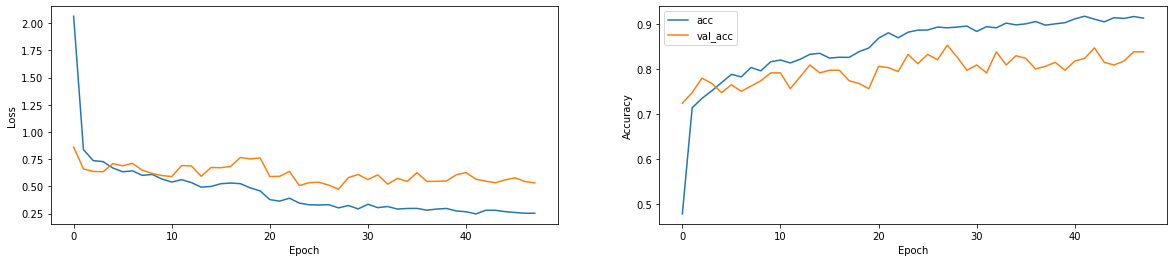

In [26]:
# Seems OK for me, no under/overfitting here

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(history.history['accuracy'], label='acc')
axs[1].plot(history.history['val_accuracy'], label='val_acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.legend();
plt.show();

### Inference

In [29]:
inference_model = tf.keras.models.load_model(config.checkpt_directory)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_func)
test_ds = train_gen.flow_from_directory(
    os.path.join(config.dataset_directory, "test/"),
    seed=config.seed,
    target_size=(config.img_width, config.img_height),
    batch_size=config.batch_size,
    shuffle=False)

y_pred = inference_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

Found 372 images belonging to 10 classes.


### Confusion Matrix

In [30]:
class_names = test_ds.class_indices
class_names_list = list(class_names.keys())
class_names = {v: k for k, v in class_names.items()}

y_pred_labels = [class_names[x] for x in y_pred]
y_true_labels = [class_names[x] for x in test_ds.classes]
cm = confusion_matrix(y_pred_labels, y_true_labels)

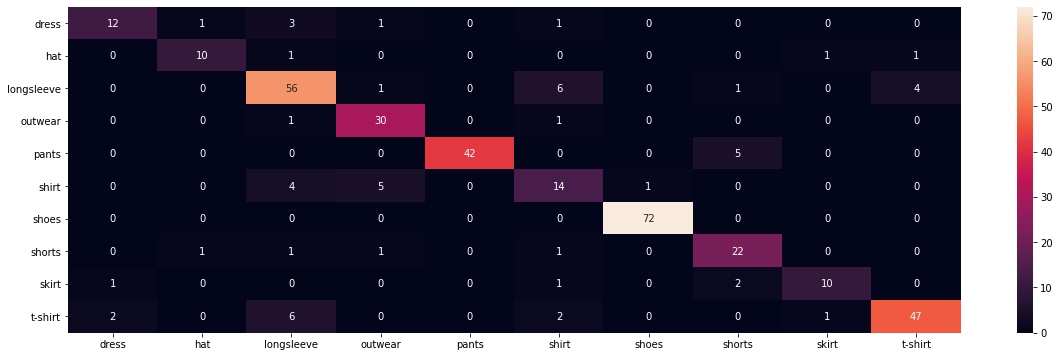

In [31]:
plt.figure(figsize=(20, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names_list, yticklabels=class_names_list)
plt.show()